# RP-GPFA: Textured Bouncing-Ball

Recognition Parametrised GPFA (RP-GPFA) recovers a latent variable (the ball) that stochastically modulates
observed pixel intensity.
The Mean and Variance of each pixel remains constant, only higher moments depends on the ball position.

Imports:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from recognition_parametrised_gpfa import RPGPFA
from utils_process import plot_summary, plot_factors_prior, plot_loss
from utils_generate_toydatasets import generate_2D_latent, generate_skewed_pixel_from_latent

# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

# GPUs ?
dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Generate Observations:

In [2]:
# Dimension of the observations
num_observation = 20
dim_observation = 20
len_observation = 50
num_inducing = 20

# Oscillation Speed
omega = 0.5

# Oscillations Parameters
F = 10  # Sampling Frequency [Hz]
T = int(len_observation / F)  # Sample Length [sec]

# Random initializations and Oscillation
theta = 2*np.pi*np.random.rand(num_observation)
z0 = torch.tensor(np.array([np.cos(theta), np.sin(theta)]).T)
zt, _ = generate_2D_latent(T, F, omega, z0)

# Distribution parameters
scale_th = 0.15
shape_max_0 = 1000
sigma2 = 0.01

# True Latent
latent_true = zt[:, 1:, 0] .unsqueeze(-1)

# Sample Observations
samples = generate_skewed_pixel_from_latent(latent_true, dim_observation, scale_th=scale_th, sigma2=sigma2)

# Convert Observations
observations = torch.tensor(samples, dtype=dtype, device=device)

Plot Distribution and Typical Sample

Mean1: -5.33e-04| Var1: 1.00e+00
Mean2: 2.63e-03| Var2: 1.01e+00


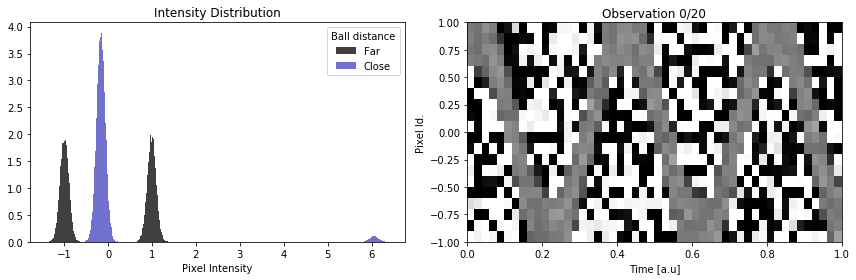

In [3]:
# Sample from distribution
N = 100000
latent_test = torch.empty(N, 3, 1)
latent_test[:, 0, 0] = 1
latent_test[:, 1, 0] = 0
latent_test[:, 2, 0] = -1
observation_samples = generate_skewed_pixel_from_latent(latent_test, 30, scale_th=scale_th, sigma2=sigma2)

# Plot Distribution
plt.figure(figsize=(6 * 2, 4))
plt.subplot(1, 2, 1)
s1 = observation_samples[:, 0, 0]
s2 = observation_samples[:, 0, 24]
plt.hist(s1, bins=500, density=True, alpha=0.75, color=[0.00, 0.00, 0.00], label='Far')
plt.hist(s2, bins=500, density=True, alpha=0.75, color=[0.25, 0.25, 0.75], label='Close')
plt.xlabel('Pixel Intensity')
plt.title('Intensity Distribution')
plt.legend(title='Ball distance')
print('Mean1: %.2e' % s1.mean() + '| Var1: %.2e' % s1.var())
print('Mean2: %.2e' % s2.mean() + '| Var2: %.2e' % s2.var())

# Plot Typical Observation
egobs = 0
pixel_plot = [0, int(dim_observation / 4), 4 * int(dim_observation / 4) -1  ]
plot_observations = not(torch.cuda.is_available())
plt.subplot(1, 2, 2)
plt.imshow(samples[0].transpose(-1, -2), aspect='auto', cmap='gray', extent=[0, 1, -1, 1], vmin=-1, vmax=1)
plt.title('Observation ' + str(egobs) + '/' + str(num_observation))
plt.ylabel('Pixel Id.')
plt.xlabel('Time [a.u]')
plt.tight_layout()



Init and Fit:

In [4]:
# Set up observation / inducing locations
inducing_locations = torch.linspace(0, 1, num_inducing, dtype=dtype, device=device).unsqueeze(-1)
observation_locations = torch.linspace(0, 1, len_observation, dtype=dtype, device=device).unsqueeze(-1)
observations = (observations,)

fit_params = {'dim_latent': 1,
              'constraint_factors': 'fixed_diag',
              'num_epoch': 5000,
              'optimizer_prior': {'name': 'Adam', 'param': {'lr': 1e-3}},
              'optimizer_factors': {'name': 'Adam', 'param': {'lr': 1e-3}},
              'optimizer_inducing_points': {'name': 'Adam', 'param': {'lr': 1e-3}},
              'gp_kernel': 'RBF',
              'dim_hidden': ([20],),
              'nn_type': ('perceptron',),
              'fit_prior_mean': True,
              'pct':0.1}

# Init Model
model = RPGPFA(observations, observation_locations,
               inducing_locations=inducing_locations, fit_params=fit_params)

# Fit Model
loss_tot = model.fit(observations)

RP-GPFA on GPU
Epoch 500/5000 Loss: 2.887194e+00
Epoch 1000/5000 Loss: 2.522193e+00
Epoch 1500/5000 Loss: 2.395245e+00
Epoch 2000/5000 Loss: 2.318657e+00
Epoch 2500/5000 Loss: 2.264856e+00
Epoch 3000/5000 Loss: 2.223656e+00
Epoch 3500/5000 Loss: 2.189424e+00
Epoch 4000/5000 Loss: 2.162231e+00
Epoch 4500/5000 Loss: 2.138670e+00
Epoch 5000/5000 Loss: 2.121274e+00


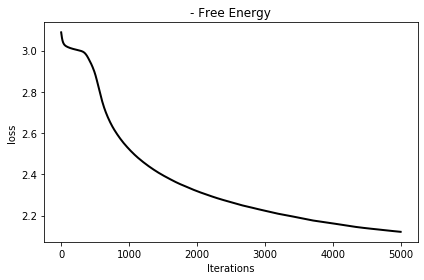

In [5]:
plot_loss(model)

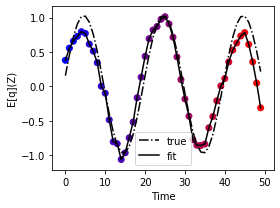

In [6]:
plot_summary(model, latent_true=latent_true.to(device), plot_observation=[1], plot_factors_id=[-1], plot_regressed='linear')